# Computational Requirements Comparison Across Architectures

This notebook visualizes how computational cost scales with the number of input channels
for different sleep staging architectures.

## Purpose

Compare the computational complexity of four fusion strategies as the number of EEG
and EOG channels increases. This helps understand the trade-offs between model
expressiveness and computational cost.

## Architectures Compared

| Architecture | Scaling Behavior |
|--------------|------------------|
| **Early fusion** | Linear in channels - attention first, then single U-Net pass |
| **AnySleep (mid)** | Linear in channels - shared encoder, attention on skip connections |
| **Late fusion** | Linear in channels - but higher constant (full U-Net per channel) |
| **U-Sleep** | Quadratic (N_EEG × N_EOG) - separate model per channel pair + voting |

## Computational Steps Model

Steps are counted as passes through major network components:
- Channel encoder/attention blocks
- U-Net encoder blocks (×12 depth)
- U-Net decoder blocks (×12 depth)
- Segment classifier

## Output

- `architecture_compute_reqs.svg`: Bar chart comparing computational steps for
  various (N_EEG, N_EOG) configurations

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def calculate_total_steps(n_eeg, n_eog, architecture):
    """Calculate total computational steps for given EEG/EOG channels and architecture"""

    if architecture == 'Early fusion':
        # (N_EEG + N_EOG) × channel encoder + 4 × channel attention + 1 × (encoder + decoder + segment classifier)
        channel_encoder = (n_eeg + n_eog) * 1
        channel_attention = 4 * 1
        encoder = 1 * 12
        decoder = 1 * 12
        segment_classifier = 1 * 1
        total = channel_encoder + channel_attention + encoder + decoder + segment_classifier

    elif architecture == 'AnySleep':
        # (N_EEG + N_EOG) × encoder + 12 × channel attention + 1 × (decoder + segment classifier)
        encoder = (n_eeg + n_eog) * 12
        channel_attention = 12 * 1
        decoder = 1 * 12
        segment_classifier = 1 * 1
        total = encoder + channel_attention + decoder + segment_classifier

    elif architecture == 'Late fusion':
        # (N_EEG + N_EOG) × (encoder + decoder) + 1 × (channel attention + segment classifier)
        encoder = (n_eeg + n_eog) * 12
        decoder = (n_eeg + n_eog) * 12
        channel_attention = 1 * 1
        segment_classifier = 1 * 1
        total = encoder + decoder + channel_attention + segment_classifier

    elif architecture == 'U-Sleep':
        # (N_EEG × N_EOG) × (encoder + decoder + segment classifier) + majority voting
        encoder = (n_eeg * n_eog) * 12
        decoder = (n_eeg * n_eog) * 12
        segment_classifier = (n_eeg * n_eog) * 1
        majority_voting = 1  # Single step for majority voting
        total = encoder + decoder + segment_classifier + majority_voting

    return total

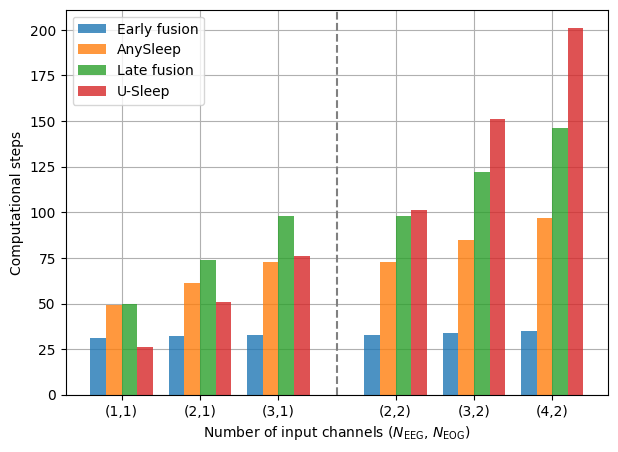

In [2]:
plt.figure(figsize=(7, 5))

config_labels = ['(1,1)', '(2,1)', '(3,1)', '(2,2)', '(3,2)', '(4,2)']
configs = [(1, 1), (2, 1), (3, 1), (2, 2), (3, 2), (4, 2)]
architectures = ['Early fusion', 'AnySleep', 'Late fusion', 'U-Sleep']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

arch_data = {arch: [] for arch in architectures}

for n_eeg, n_eog in configs:
    for arch in architectures:
        steps = calculate_total_steps(n_eeg, n_eog, arch)
        arch_data[arch].append(steps)

x = np.arange(len(config_labels))
width = 0.2

for i, (arch, color) in enumerate(zip(architectures, colors)):
    plt.bar(x[:3] + i * width, arch_data[arch][:3], width, label=arch, color=color, alpha=0.8)
    plt.bar(x[3:] + i * width + 0.5, arch_data[arch][3:], width, color=color, alpha=0.8)

plt.xlabel('Number of input channels ($N_{\\text{EEG}}$, $N_{\\text{EOG}})$')
plt.ylabel('Computational steps')
plt.xticks(np.r_[x[:3] + width * 1.5, x[3:] + width * 1.5 + 0.5], config_labels)
plt.axvline(x=3.05, color='gray', linestyle='--')
ax = plt.gca()
ax.tick_params(
    axis='both',
    which='both',
    bottom=True,
    top=False,
    left=True, )
plt.legend()
plt.grid()
# put grid lines behind bars
plt.gca().set_axisbelow(True)
plt.savefig('architecture_compute_reqs.svg')